# Clones, Installs, and Imports

In [1]:
!git clone https://github.com/zlisto/opinion_dynamics
import os
os.chdir("opinion_dynamics")


Cloning into 'opinion_dynamics'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 94 (delta 35), reused 34 (delta 7), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [2]:
!pip install -r requirements.txt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 6.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [3]:
from scipy import integrate
from scipy.integrate import odeint
from scipy.sparse import coo_matrix,diags


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.opinion_data import *
from scripts.opinion_dynamics_gym import *
from scripts.opinion_visualization import *

pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({"axes.grid" : True})
plt.rcParams["figure.figsize"] = (18, 10)

# Opinion Shift and dShift Functions

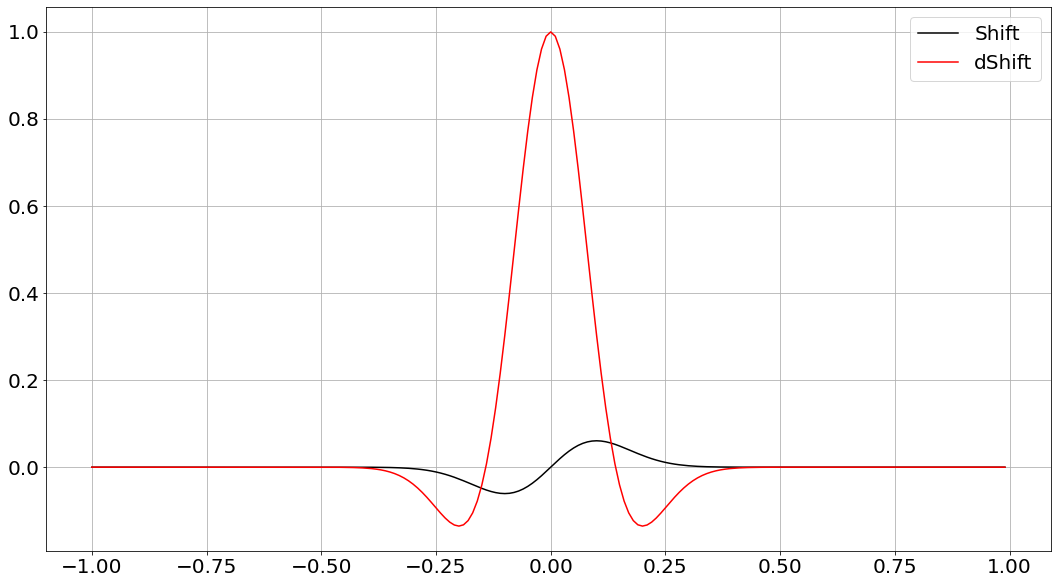

In [4]:
PEAK = 0.1
def hk_shift(shift):
  return shift*np.exp(-shift**2/2/PEAK **2)

def hk_dshift(shift):
  return (1-shift**2/2/PEAK**2)*np.exp(-shift**2/2/PEAK **2)

u = np.arange(-1,1,0.01)
plt.plot(u,hk_shift(u), 
         color = 'black', label = 'Shift')
plt.plot(u,hk_dshift(u), 
         color = 'red', label = 'dShift')
plt.legend()

# Load Simulator Dataset

## Toy networks

In [ ]:
# Toy networks
opinions_initial = np.array([1,0.0,]).astype(float)
G = nx.DiGraph()
#edges = [(0,1),(1,0), (0,2),(2,0),(1,2),(2,1)]
edges =[(0,1)]
for edge in edges:
  G.add_edge(edge[0],edge[1])


n = G.number_of_nodes()
rate = np.ones(n)  #tweet rate [tweets/day]
shift_function = hk_shift
dshift_function = hk_dshift
dt = 0.5  #time step [days]
P_final = np.ones(n)/n
max_steps = 60

## Brexit Network

In [13]:
G, opinions_initial, rate , mapping = load_brexit()
nv = G.number_of_nodes()
assert len(opinions_initial) == nv
assert len(rate) == nv

rate = rate/30  #tweet rate [tweets/day]
shift_function = hk_shift
dshift_function = hk_dshift
dt = 10/np.sum(rate)  #time step [days]
P_final = np.ones(nv)/nv
max_steps = np.round(7/dt)

print(f"Simulator will run for {max_steps} steps covering {dt*max_steps:.3f} days")
print(f"Network has {nv} nodes")
print(f"Mean user rate = {rate.mean():.2f} tweets/day")

Simulator will run for 7047.0 steps covering 7.000 days
Network has 1514 nodes
Mean user rate = 6.65 tweets/day


## Gilets Jaunes Network

In [5]:
G, opinions_initial, rate , mapping = load_brexit()
nv = G.number_of_nodes()
assert len(opinions_initial) == nv
assert len(rate) == nv

rate = rate/30  #tweet rate [tweets/day]
shift_function = hk_shift
dshift_function = hk_dshift
dt = 10/np.sum(rate)  #time step [days]
P_final = np.ones(nv)/nv
max_steps = np.round(7/dt)

print(f"Simulator will run for {max_steps} steps covering {dt*max_steps:.3f} days")
print(f"Network has {nv} nodes")
print(f"Mean user rate = {rate.mean():.2f} tweets/day")

Simulator will run for 7047.0 steps covering 7.000 days
Network has 1514 nodes
Mean user rate = 6.65 tweets/day


# Agent and Simulate

## Agent Targets, Rate

1) `targets` = array of indices of targets in network (not their user_ids)

2) `agent_rate` = tweet rate of agent

In [6]:
 #define agent parameters
targets = np.array([x for x in range(500,550)])
assert len(targets)<=nv
agent_rate = 20   

G_agent = G.copy()
for target in targets:
  G_agent.add_edge('agent',target)
if nv <=10:
  nx.draw(G_agent,with_labels=True,node_size = 10000, width = 2)



In [7]:
env = OpinionSimulatorContinuous(rate, shift_function, G, opinions_initial,dt, max_steps)
env_P = AdjointSimulatorContinuous(rate, dshift_function, G, P_final, dt, max_steps)

/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:38: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A =  nx.adjacency_matrix(G)
/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:109: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A =  nx.adjacency_matrix(G)


## Simulate Opinions and Adjoint 

Opinion simulated forward in time.

Adjoint simulated backwards in time.

/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:135: RuntimeWarning: overflow encountered in multiply
  L = self.P*dd #contribution from following of node (its Leaders)
/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:142: RuntimeWarning: invalid value encountered in multiply
  LA = self.P*b*self.dshift(action.opinion-opinions) #contribution from agent (its Leader Agent)


quantile plot


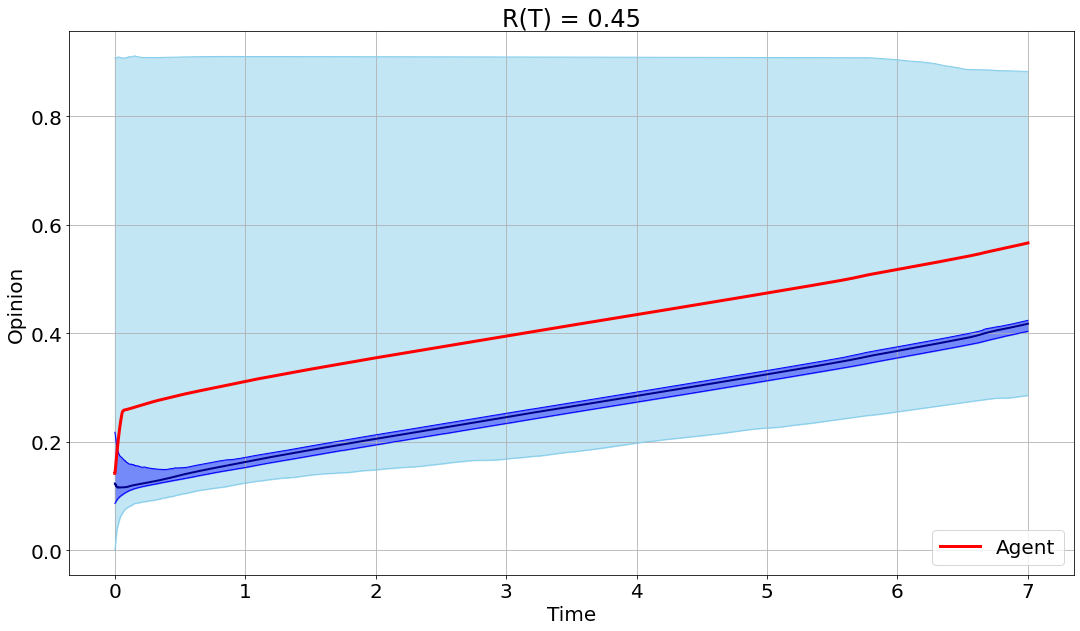

In [8]:
#%%time
iswitch = 0

  
opinions = []
agent_opinions = []
agent_rates = []

#############
i = 0
state, done = env.reset()
psign = pull_sign(i, iswitch)
agent_opinion = clip(state[targets].min() + PEAK*np.sqrt(2)*psign)
opinions.append(state)
agent_opinions.append(agent_opinion)

while not done:
  i+=1
  action = Action(agent_opinion, agent_rate, targets)
  state, done = env.step(action)
  psign = pull_sign(i, iswitch)
  agent_opinion = clip(state[targets].min() + PEAK*np.sqrt(2)*psign)
  agent_opinions.append(agent_opinion)
  agent_rates.append(agent_rate)
  opinions.append(state)

reward = state.mean()

opinions = np.array(opinions)
agent_opinions = np.array(agent_opinions)
#Adjoint
P = np.zeros(opinions.shape)
state, done = env_P.reset()
i = P.shape[0]-1
P[i,:] = state
while not done:
  i-=1
  agent_opinion = agent_opinions[i]
  agent_rate = agent_rates[i]
  opinion = opinions[i,:]
  action = Action(agent_opinion, agent_rate, targets)

  state, done = env_P.step(action, opinion)
  P[i,:] = state

plot_opinions(opinions, agent_opinions, dt, reward, quantile_plot = True)
#plot_opinions_adjoint(opinions, agent_opinions, P, dt, reward)

# Optimize Over Switching Time

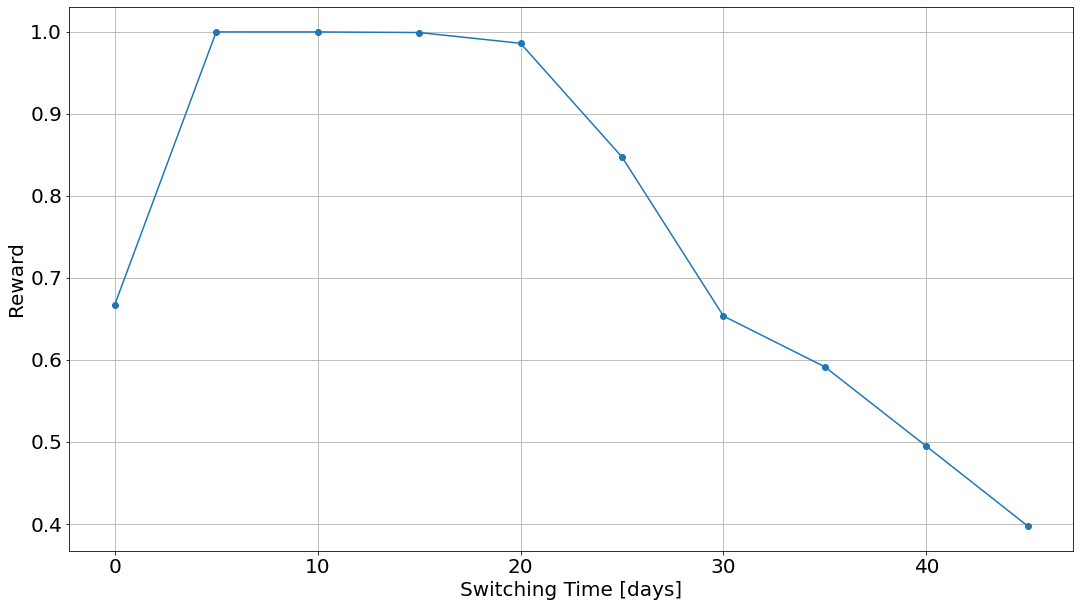

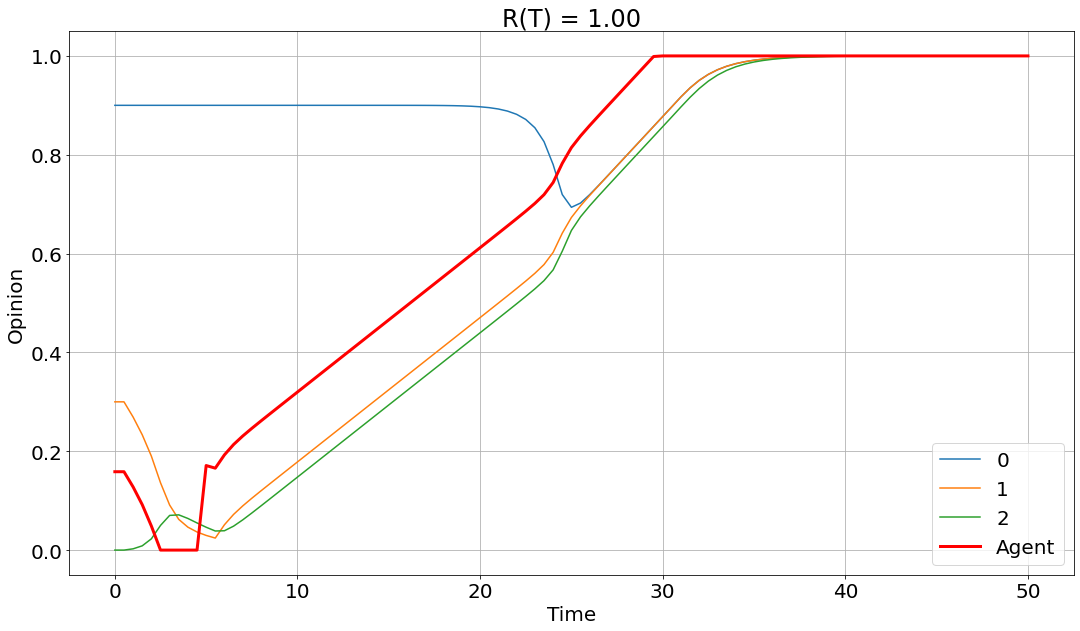

In [ ]:
iswitches = np.arange(0,max_steps, 10)
def bang_bang(env, agent_rate, targets, iswitches, VERBOSE = True ):
  rewards = np.zeros(iswitches.shape)
  reward_best = -np.inf
  agent_opinions_best = np.inf
  for cnt, iswitch in enumerate(iswitches):
    opinions = []
    i = 0
    state, done = env.reset()
    opinions.append(state)
    agent_opinions = []
    agent_rates = []

    while not done:
      i+=1
      if i<=iswitch:
        psign = -1
      else: psign = 1
      agent_opinion = state[targets].min()+PEAK*np.sqrt(2)*psign
      agent_opinion = min(1,max(0,agent_opinion))
      agent_opinions.append(agent_opinion)
      agent_rates.append(agent_rate)
      action = Action(agent_opinion, agent_rate, targets)
    
      state, done = env.step(action)
      opinions.append(state)

    opinions = np.array(opinions)
    reward = state.mean()
    rewards[cnt] = reward

    if iswitch%10==0 and VERBOSE: 
      print(f"iswitch = {iswitch}: Reward  = {reward:.2f}")

    if reward > reward_best:
      if VERBOSE:
        print(f"\ttswitch = {iswitch*env.dt:.3f}: Reward Best/New Reward = {reward_best:.2f}/{reward:.2f}")
      reward_best = reward
      iswitch_best = iswitch
      agent_opinions_best = agent_opinions
      agent_rate_best = agent_rate
      opinions_best = opinions
  return agent_opinions_best, opinions_best, rewards


agent_opinions_best, opinions_best, rewards = bang_bang(env, agent_rate, targets, iswitches, False )
reward_best = np.max(rewards)
plt.plot(iswitches*env.dt, rewards, marker = 'o')
plt.xlabel("Switching Time [days]")
plt.ylabel("Reward")
plt.show()

plot_opinions(opinions_best, agent_opinions_best, env.dt, reward_best)
